In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
from scipy.stats import norm
import sys
sys.path.append('../')
import imp
import pickle

In [7]:
import mdp
imp.reload(mdp)
from mdp import get_mdp, simulate_from_mdp

In [8]:
from rl_learner import TD_Learner
import torch
from mdp import get_reward_dist_per_state

## 4 level tree (9 states)

### Create MDP

In [9]:
P, R, n_states, states = get_mdp('9tree_mix2')

9tree_mix2


### Simulate

In [10]:
(states_all, rewards_all, 
 states_onehot_all, mask) = simulate_from_mdp(1, P, R, n_states, states, 
                                              n_episodes = 10_000, max_seq_len = 4)

In [11]:
ep = 0
print(states_all[ep,])
print(rewards_all[ep,])
print(states_onehot_all[ep,])

[ 0  1  4 -1]
[1.86795706]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
ep = 10
print(states_all[ep,])
print(rewards_all[ep,])
print(states_onehot_all[ep,])

[ 0  1  4 -1]
[1.74049031]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
mask

array([[1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       ...,
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 0]])

### Plot Distribution

true thetas
[-4.81 -2.87 -1.99  1.79  2.16]


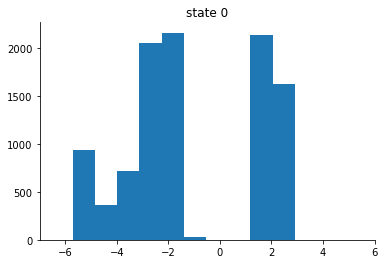

In [59]:
state = 0
rewards_per_state = get_reward_dist_per_state(state, states_all, rewards_all)
plt.hist(rewards_per_state)
plt.xlim([-7,6])
plt.title(f'state {state}')
sns.despine()

print('true thetas')
n_quantiles=5
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
thetas = [np.quantile(rewards_per_state.squeeze(), q) for q in taus]
print(np.array(thetas).round(2))


### Save 

In [16]:
# save out data 
print(states_onehot_all.shape)
print(rewards_all.shape)
np.save('../mscl/simple_mdp_mix2_states_onehot.npy', states_onehot_all)
np.save('../mscl/simple_mdp_mix2_rewards.npy', rewards_all)
np.save('../mscl/simple_mdp_mix2_mask.npy', mask)

(10000, 4, 9)
(10000, 1)


### Train RL Batch Mode

`CUDA_VISIBLE_DEVICES=3 python train_rl_batch.py --epochs 50 --batch_size 40 --hidden_dim 100 --mdp_mode --n_quantiles 20 --target_every 100 --learning_rate 1e-4`

`CUDA_VISIBLE_DEVICES=3 python train_rl_batch.py --epochs 50 --batch_size 40 --linear --mdp_mode --n_quantiles 20 --target_every 100 --learning_rate 1e-3`

`CUDA_VISIBLE_DEVICES=3 python train_rl_batch.py --epochs 50 --batch_size 40 --linear --mdp_mode --n_quantiles 20 --target_every 100 --learning_rate 1e-3 --huber_k 0.1`

`CUDA_VISIBLE_DEVICES=3 python train_rl_batch.py --epochs 50 --batch_size 40 --hidden_dim 100 --mdp_mode --n_quantiles 20 --target_every 100 --learning_rate 1e-3 --huber_k 0.1`

### Look at Log

In [17]:
n_quantiles=20
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
taus

array([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425,
       0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875,
       0.925, 0.975])

In [18]:
hidden_dim = 'linear'
hidden_dim = 100
epoch=40
huber_k = 0.1

file1 = f'../data/results/single_sentences_I_1/quantile_learner_mdp2_{hidden_dim}_{huber_k}/quantile_learner_mdp_epoch{epoch}.pkl'
file2=f'../data/results/single_sentences_I_1/quantile_learner_mdp2_{hidden_dim}_{huber_k}/log_quantile_learner_mdp_epoch{epoch}.pkl'


Z_network = TD_Learner(n_states, n_quantiles, hidden_dim=hidden_dim)
#Z_network = TD_Learner(n_states, n_quantiles, hidden_dim=None)

Z_network.load_state_dict(torch.load(file1, map_location=torch.device('cpu')))
log = pickle.load(open(file2,'rb'))

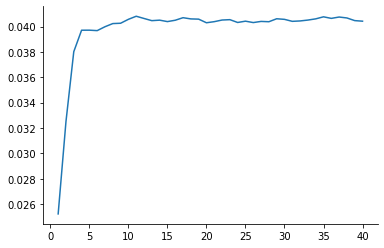

In [19]:
loss = np.array(log['loss'])
epoch = np.array(log['epoch'])
plt.plot(epoch, loss)
sns.despine()

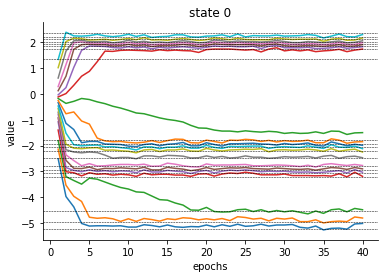

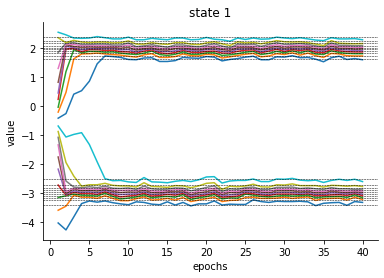

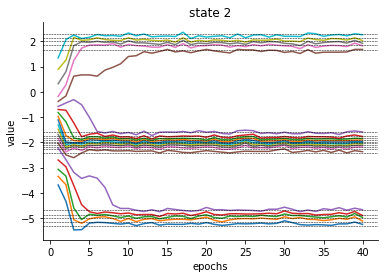

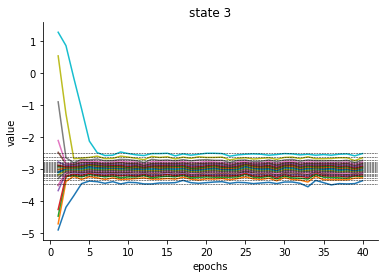

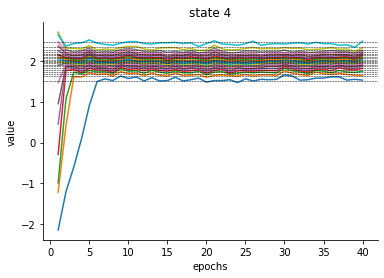

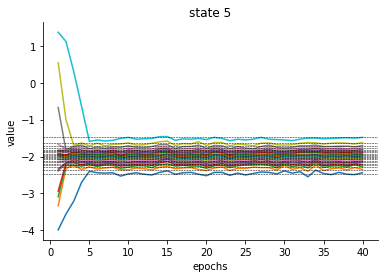

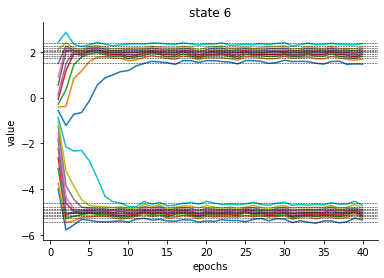

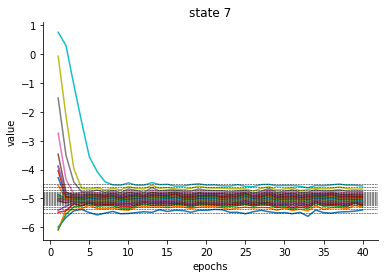

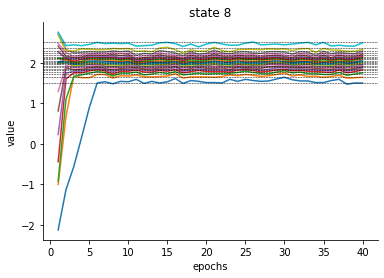

In [20]:
for state in range(9):
    theta_ests = np.array(log[f'state {state}'])
    plt.figure()
    plt.title(f'state {state}')
    plt.plot(epoch, theta_ests); 
    sns.despine()
    
    rewards_per_state = get_reward_dist_per_state(state, states_all, rewards_all)
    thetas = np.array([np.quantile(rewards_per_state.squeeze(), q) for q in taus]).round(2)
    for theta in thetas:
        plt.axhline(y=theta, linestyle='--', color='k', linewidth=0.5)
    plt.ylabel('value')
    plt.xlabel('epochs')
    

In [21]:
taus

array([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425,
       0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875,
       0.925, 0.975])

### Look at Distributions and Compare to TD Learner

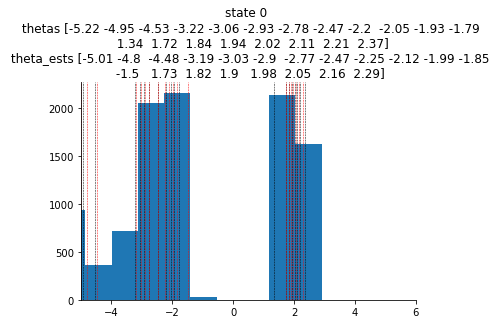

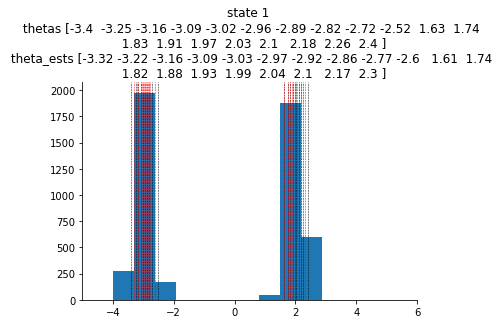

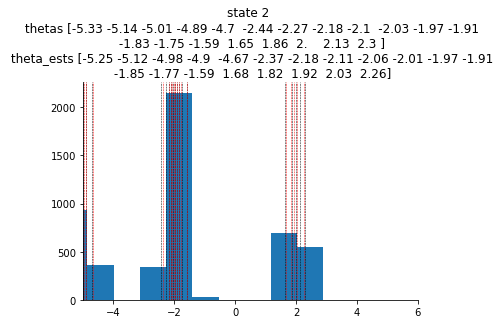

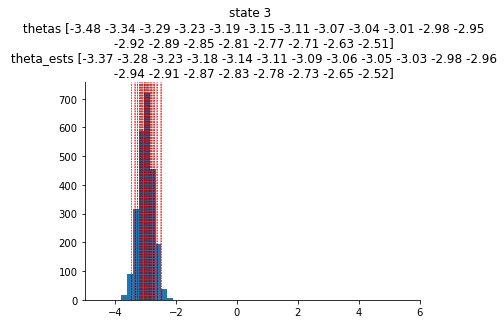

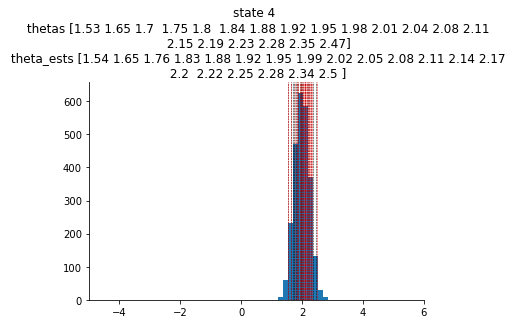

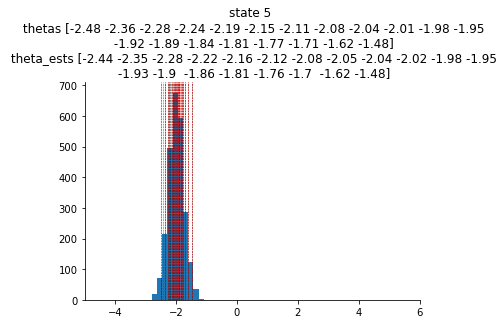

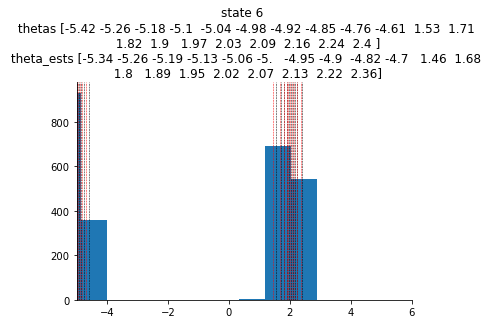

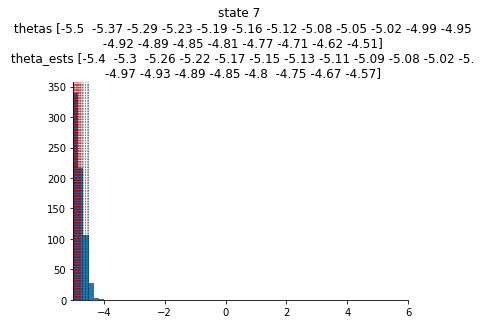

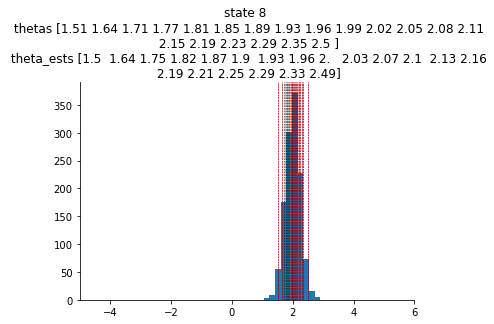

In [22]:
for state in range(9):
    
    rewards_per_state = get_reward_dist_per_state(state, states_all, rewards_all)
    
    # plot actual distribution 
    plt.figure()
    plt.title(f'state {state}')
    plt.hist(rewards_per_state)
    plt.xlim([-5,6])
    plt.title(f'state {state}')
    sns.despine()
    
    # print true thetas 
    #print('true thetas')
    thetas = np.array([np.quantile(rewards_per_state.squeeze(), q) for q in taus]).round(2)
    for theta in thetas:
        plt.axvline(x=theta, linestyle='--', color='k', linewidth=0.5)
    
    #print(np.array(thetas).round(2))
    
    # print estimates 
    #print('theta estimates')
    state_onehot = np.zeros(n_states)
    state_onehot[state]=1
    theta_ests = Z_network(torch.Tensor(state_onehot)).detach().cpu().numpy().round(2)
    for theta in theta_ests:
        plt.axvline(x=theta, linestyle='--', color='r', linewidth=0.5)
    
    plt.title(f'state {state} \n thetas {thetas}\n theta_ests {theta_ests}')

## Forward Sampling

In [23]:
import cvar_sampler
imp.reload(cvar_sampler)
from cvar_sampler import cvar_forward_sampler

### alpha 0.1

In [24]:
import cvar_sampler
imp.reload(cvar_sampler)
from cvar_sampler import cvar_forward_sampler
from cvar_helpers import calc_cvar_from_samples

In [25]:
alpha0=0.1
s0=0
(states_all2, 
 rewards_all2, 
 alphas_all2) = cvar_forward_sampler(P, R, s0, alpha0, n_eps=1000, 
                                     n_quantiles = 10, verbose = False,
                                     states_all_prev=states_all, rewards_all_prev=rewards_all,
                                     max_seq_len=4)


/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [26]:
print(states_all2[0:5])
print(rewards_all2[0:5])

[[0 2 6 7]
 [0 2 6 7]
 [0 2 6 7]
 [0 2 6 7]
 [0 2 6 7]]
[-5.35464667 -4.80869397 -4.71670712 -4.68916677 -5.22316514]


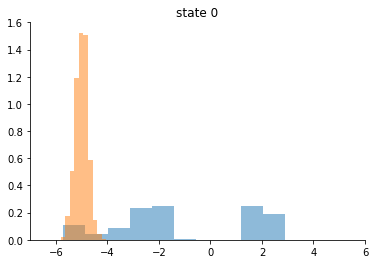

In [28]:
state = 0

plt.hist(get_reward_dist_per_state(state, states_all, rewards_all), alpha=0.5, density=True)
plt.hist(get_reward_dist_per_state(state, states_all2, rewards_all2), alpha=0.5, density=True)

plt.xlim([-7,6])
plt.title(f'state {state}')
sns.despine()

In [39]:
terminal_states = np.max(states_all,axis=1)

In [40]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.    , 0.2426],
       [4.    , 0.2522],
       [5.    , 0.252 ],
       [7.    , 0.1293],
       [8.    , 0.1239]])

In [41]:
sort_idx = np.argsort(rewards_all.flatten(),axis=0)
#rewards_all[sort_idx][0:int(len(rewards_all)*alpha0)]

In [42]:
(unique, counts) = np.unique(terminal_states[sort_idx][0:int(len(rewards_all)*alpha0)], return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[7., 1.]])

In [43]:
terminal_states = np.max(states_all2,axis=1)

In [44]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[7., 1.]])

In [45]:
returns_cvar = get_reward_dist_per_state(state, states_all2, rewards_all2)
returns_all = get_reward_dist_per_state(state, states_all, rewards_all)

In [46]:
var, cvar = calc_cvar_from_samples(returns_all, alpha0)
print(cvar)
print(np.mean(returns_cvar))

[-5.09954855]
-5.002672027836804


### alpha 0.2

In [47]:
import cvar_sampler
imp.reload(cvar_sampler)
from cvar_sampler import cvar_forward_sampler
from cvar_helpers import calc_cvar_from_samples

In [48]:
alpha0=0.2
s0=0
(states_all2, 
 rewards_all2, 
 alphas_all2) = cvar_forward_sampler(P, R, s0, alpha0, n_eps=1000, 
                                     n_quantiles = 10, verbose = False,
                                     states_all_prev=states_all, rewards_all_prev=rewards_all,
                                     max_seq_len=4)


In [49]:
print(states_all2[0:5])
print(rewards_all2[0:5])

[[ 0  2  6  7]
 [ 0  1  3 -1]
 [ 0  2  6  7]
 [ 0  2  6  7]
 [ 0  1  3 -1]]
[-4.97495825 -2.66312387 -4.84379494 -5.03212658 -3.28561746]


[-4.39557135]
-4.124476673093104


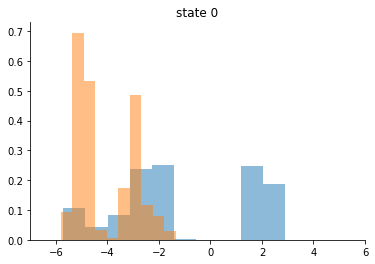

In [61]:
state = 0

plt.hist(get_reward_dist_per_state(state, states_all, rewards_all), alpha=0.5, density=True)
plt.hist(get_reward_dist_per_state(state, states_all2, rewards_all2), alpha=0.5, density=True)

plt.xlim([-7,6])
plt.title(f'state {state}')
sns.despine()

var, cvar = calc_cvar_from_samples(returns_all, alpha0)
print(cvar)
print(np.mean(returns_cvar))
#plt.axvline(x=np.mean(returns_cvar), color=sns.color_palette()[1])
#plt.axvline(x=cvar, color=sns.color_palette()[0])

In [51]:
terminal_states = np.max(states_all,axis=1)

In [52]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.    , 0.2426],
       [4.    , 0.2522],
       [5.    , 0.252 ],
       [7.    , 0.1293],
       [8.    , 0.1239]])

In [53]:
sort_idx = np.argsort(rewards_all.flatten(),axis=0)
#rewards_all[sort_idx][0:int(len(rewards_all)*alpha0)]

In [54]:
(unique, counts) = np.unique(terminal_states[sort_idx][0:int(len(rewards_all)*alpha0)], return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.    , 0.3535],
       [7.    , 0.6465]])

In [55]:
terminal_states = np.max(states_all2,axis=1)

In [56]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.   , 0.337],
       [5.   , 0.06 ],
       [7.   , 0.603]])

In [57]:
returns_cvar = get_reward_dist_per_state(state, states_all2, rewards_all2)
returns_all = get_reward_dist_per_state(state, states_all, rewards_all)

[-4.39557135]
-4.124476673093104


### alpha 0.5

In [73]:
import cvar_sampler
imp.reload(cvar_sampler)
from cvar_sampler import cvar_forward_sampler
from cvar_helpers import calc_cvar_from_samples

In [74]:
alpha0=0.5
s0=0
(states_all2, 
 rewards_all2, 
 alphas_all2) = cvar_forward_sampler(P, R, s0, alpha0, n_eps=1000, 
                                     n_quantiles = 10, verbose = False,
                                     states_all_prev=states_all, rewards_all_prev=rewards_all,
                                     max_seq_len=4)


/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [75]:
print(states_all2[0:5])
print(rewards_all2[0:5])

[[ 0  2  6  7]
 [ 0  2  5 -1]
 [ 0  2  5 -1]
 [ 0  2  5 -1]
 [ 0  2  6  7]]
[-5.056734   -1.52410464 -1.96435823 -2.12582892 -5.14649102]


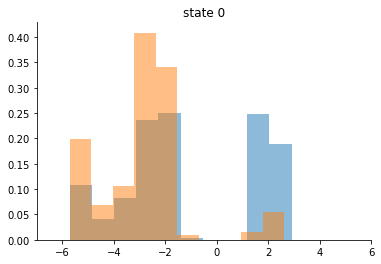

In [76]:
state = 0

plt.hist(get_reward_dist_per_state(state, states_all, rewards_all), alpha=0.5, density=True)
plt.hist(get_reward_dist_per_state(state, states_all2, rewards_all2), alpha=0.5, density=True)

plt.xlim([-7,6])
plt.title(f'state {state}')
sns.despine()


In [77]:
terminal_states = np.max(states_all,axis=1)

In [78]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.    , 0.2426],
       [4.    , 0.2522],
       [5.    , 0.252 ],
       [7.    , 0.1293],
       [8.    , 0.1239]])

In [79]:
sort_idx = np.argsort(rewards_all.flatten(),axis=0)
#rewards_all[sort_idx][0:int(len(rewards_all)*alpha0)]

In [80]:
(unique, counts) = np.unique(terminal_states[sort_idx][0:int(len(rewards_all)*alpha0)], return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.    , 0.4852],
       [5.    , 0.2562],
       [7.    , 0.2586]])

In [81]:
terminal_states = np.max(states_all2,axis=1)

In [82]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.   , 0.409],
       [5.   , 0.311],
       [7.   , 0.223],
       [8.   , 0.057]])

In [83]:
returns_cvar = get_reward_dist_per_state(state, states_all2, rewards_all2)
returns_all = get_reward_dist_per_state(state, states_all, rewards_all)

In [84]:

var, cvar = calc_cvar_from_samples(returns_all, alpha0)
print(cvar)
print(np.mean(returns_cvar))


[-3.3087257]
-2.8576938203816673
